# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/image_quilting/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

output_dir = datadir + "output"
os.makedirs(output_dir, exist_ok=True)

In [3]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [4]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    output = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)

    num_patches = out_size // patch_size
    max_x = sample.shape[1] - patch_size
    max_y = sample.shape[0] - patch_size

    for i in range(num_patches):
      for j in range(num_patches):
        x = np.random.randint(0, max_x + 1)
        y = np.random.randint(0, max_y + 1)
        patch = sample[y : y+patch_size, x : x+patch_size]
        output[i*patch_size : (i+1)*patch_size, j*patch_size : (j+1)*patch_size] = patch

    return output


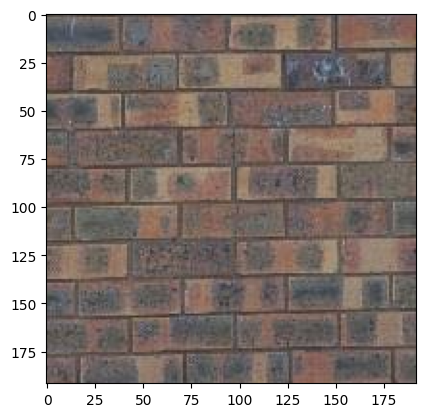

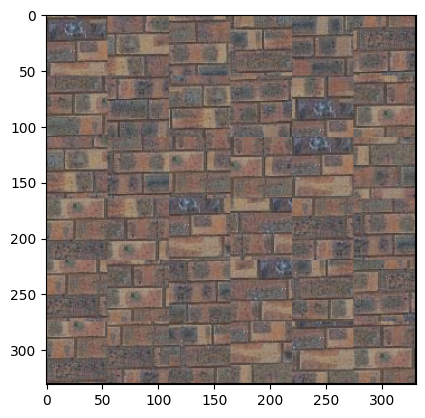

In [36]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 331  # change these parameters as needed
patch_size = 55
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)
    plt.imsave(os.path.join(output_dir, "random_sampled.png"), res)

### Part II: Overlapping Patches (30 pts)

In [6]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    def ssd_patch(template, mask):
      I = np.float32(sample / 255)
      T = np.float32(template / 255)
      M = np.float32(mask)
      template_masked = M * T
      ssd_cost = (template_masked ** 2).sum() -\
            2 * cv2.filter2D(I, ddepth=-1, kernel=template_masked) +\
            cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
      ssd_cost = np.sum(ssd_cost, axis=2)

      # Process the border to ensure not sampling them.
      half = patch_size // 2
      max_cost = ssd_cost.max()
      ssd_cost[:half+1, :] = max_cost
      ssd_cost[:, :half+1] = max_cost
      ssd_cost[-half-1:, :] = max_cost
      ssd_cost[:, -half-1:] = max_cost
      return ssd_cost


    def choose_sample(cost):
      idx = np.unravel_index(np.argsort(cost, axis=None), cost.shape)
      t = np.random.randint(0, tol)
      return idx[0][t], idx[1][t]


    output = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)

    half = patch_size // 2
    step = patch_size - overlap
    num_patches = (out_size - patch_size) // step + 1

    # Sample a random patch for the upper-left corner.
    x = np.random.randint(0, sample.shape[1] - patch_size + 1)
    y = np.random.randint(0, sample.shape[0] - patch_size + 1)
    patch = sample[y : y+patch_size, x : x+patch_size]
    output[0 : patch_size, 0 : patch_size] = patch

    for i in range(num_patches):
      for j in range(num_patches):
        # Generate the mask according to the region.
        if i == 0 and j == 0:
          continue
        mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=sample.dtype)
        if i >= 1:
          mask[0:overlap, :, :] = 1
        if j >= 1:
          mask[:, 0:overlap, :] = 1

        # Sample the patch.
        template = output[i*step : i*step+patch_size, j*step : j*step+patch_size]
        cost = ssd_patch(template, mask)
        r, c = choose_sample(cost)
        patch = sample[r-half : r+half+1, c-half : c+half+1]
        output[i*step : i*step+patch_size, j*step : j*step+patch_size] = patch

    return output

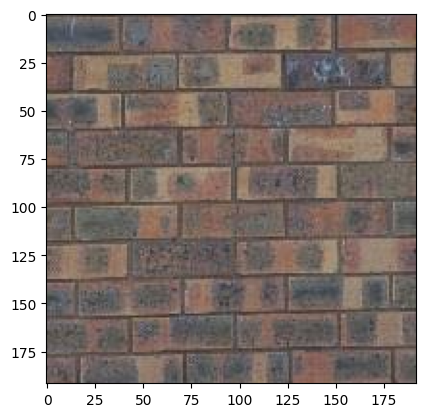

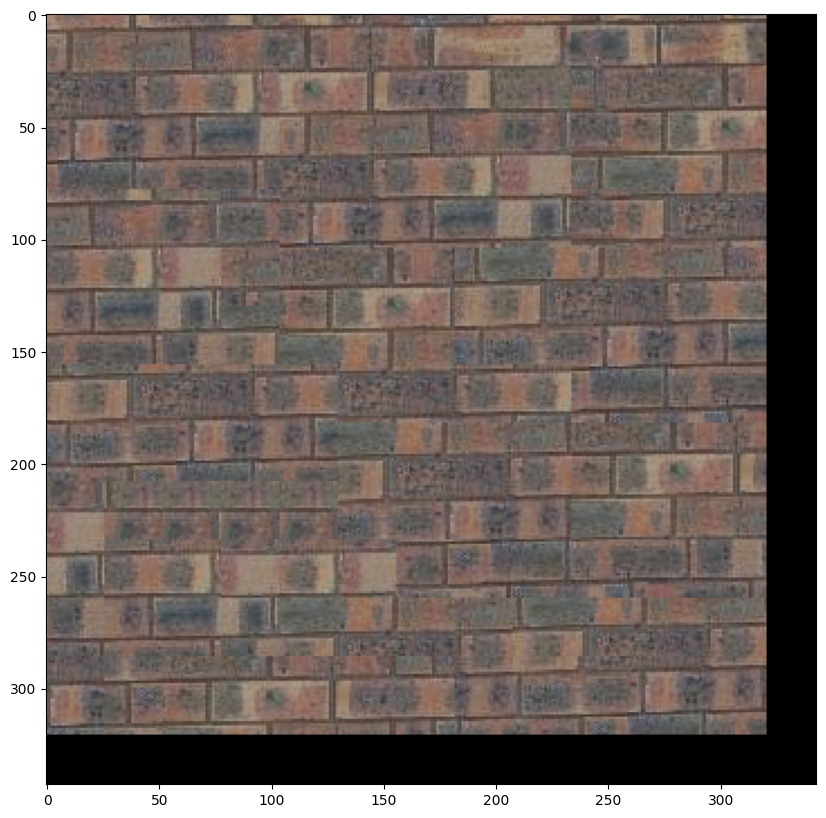

In [34]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 343  # change these parameters as needed
patch_size = 35
overlap = 9
tol = 1
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)
    plt.imsave(os.path.join(output_dir, "overlap.png"), res)

### Part III: Seam Finding (20 pts)


In [8]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [9]:
def quilt_cut(sample, out_size, patch_size, overlap, tol, display=False):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    def ssd_patch(template, mask):
      I = np.float32(sample / 255)
      T = np.float32(template / 255)
      M = np.float32(mask)
      template_masked = M * T
      ssd_cost = (template_masked ** 2).sum() -\
            2 * cv2.filter2D(I, ddepth=-1, kernel=template_masked) +\
            cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
      ssd_cost = np.sum(ssd_cost, axis=2)

      # Process the border to ensure not sampling them.
      half = patch_size // 2
      max_cost = ssd_cost.max()
      ssd_cost[:half+1, :] = max_cost
      ssd_cost[:, :half+1] = max_cost
      ssd_cost[-half-1:, :] = max_cost
      ssd_cost[:, -half-1:] = max_cost
      return ssd_cost


    def choose_sample(cost):
      idx = np.unravel_index(np.argsort(cost, axis=None), cost.shape)
      t = np.random.randint(0, tol)
      return idx[0][t], idx[1][t]


    output = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)

    half = patch_size // 2
    step = patch_size - overlap
    num_patches = (out_size - patch_size) // step + 1

    # Sample a random patch for the upper-left corner.
    x = np.random.randint(0, sample.shape[1] - patch_size + 1)
    y = np.random.randint(0, sample.shape[0] - patch_size + 1)
    patch = sample[y : y+patch_size, x : x+patch_size]
    output[0 : patch_size, 0 : patch_size] = patch

    # Process the first row.
    mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=sample.dtype)
    mask[:, 0:overlap, :] = 1
    for col in range(num_patches):
      template = output[0:patch_size, col*step : col*step+patch_size]
      cost = ssd_patch(template, mask)
      r, c = choose_sample(cost)
      patch = sample[r-half : r+half+1, c-half : c+half+1]

      err_patch = np.sum((template - patch)**2, axis=2)
      max_err = err_patch.max()
      err_patch[:, overlap:patch_size] = max_err
      cut_mask = cut(err_patch.T).T.astype(sample.dtype)
      cut_mask = np.repeat(cut_mask[:,:,np.newaxis], 3, axis=2)
      seam = cut_mask * patch + np.logical_not(cut_mask) * template
      output[0:patch_size, col*step : col*step+patch_size] = seam

    # Process the first column.
    mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=sample.dtype)
    mask[0:overlap, :, :] = 1
    for row in range(num_patches):
      template = output[row*step : row*step+patch_size, 0:patch_size]
      cost = ssd_patch(template, mask)
      r, c = choose_sample(cost)
      patch = sample[r-half : r+half+1, c-half : c+half+1]

      err_patch = np.sum((template - patch)**2, axis=2)
      max_err = err_patch.max()
      err_patch[overlap:patch_size, :] = max_err
      cut_mask = cut(err_patch).astype(sample.dtype)
      cut_mask = np.repeat(cut_mask[:,:,np.newaxis], 3, axis=2)
      seam = cut_mask * patch + np.logical_not(cut_mask) * template
      output[row*step : row*step+patch_size, 0:patch_size] = seam

    # Process the remaining patches.
    mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=sample.dtype)
    mask[0:overlap, :, :] = 1
    mask[:, 0:overlap, :] = 1
    for row in range(1, num_patches):
      for col in range(1, num_patches):
        template = output[row*step : row*step+patch_size, col*step : col*step+patch_size]
        cost = ssd_patch(template, mask)
        r, c = choose_sample(cost)
        patch = sample[r-half : r+half+1, c-half : c+half+1]

        err_patch = np.sum((template - patch)**2, axis=2)
        max_err = err_patch.max()
        err_patch[overlap:patch_size, :] = max_err
        err_patch[:, overlap:patch_size] = max_err
        cut_mask1 = cut(err_patch.T).T.astype(sample.dtype)
        cut_mask2 = cut(err_patch).astype(sample.dtype)
        cut_mask = np.logical_and(cut_mask1, cut_mask2).astype(sample.dtype)
        cut_mask = np.repeat(cut_mask[:,:,np.newaxis], 3, axis=2)
        seam = cut_mask * patch + np.logical_not(cut_mask) * template.copy()

        if display and row == 1 and col == 1:
          fig, axes = plt.subplots(1, 5, figsize=(10, 6))
          fig.patch.set_facecolor('#fffacd')
          axes[0].imshow(template)
          axes[0].set_title('Overlap Portion')
          axes[0].axis('off')
          axes[1].imshow(cost)
          axes[1].set_title('SSD Cost')
          axes[1].axis('off')
          axes[2].imshow(np.repeat(cut_mask1[:,:,np.newaxis], 3, axis=2)*255)
          axes[2].set_title('Horizontal Mask')
          axes[2].axis('off')
          axes[3].imshow(np.repeat(cut_mask2[:,:,np.newaxis], 3, axis=2)*255)
          axes[3].set_title('Vertical Mask')
          axes[3].axis('off')
          axes[4].imshow(cut_mask*255)
          axes[4].set_title('Combination Mask')
          axes[4].axis('off')
          plt.savefig(os.path.join(output_dir, "seam_mask.png"), dpi=300, bbox_inches='tight')
          plt.show()

          plt.imsave(os.path.join(output_dir, "seam_patch.png"), patch)
          plt.imsave(os.path.join(output_dir, "seam_result.png"), seam)

        output[row*step : row*step+patch_size, col*step : col*step+patch_size] = seam

    return output

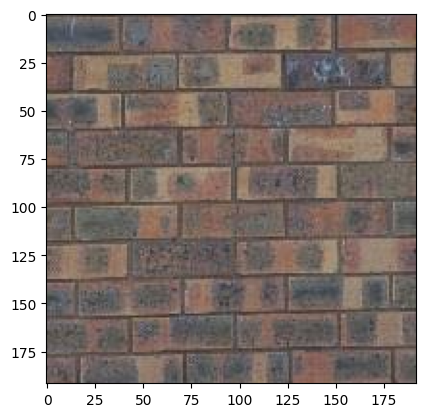

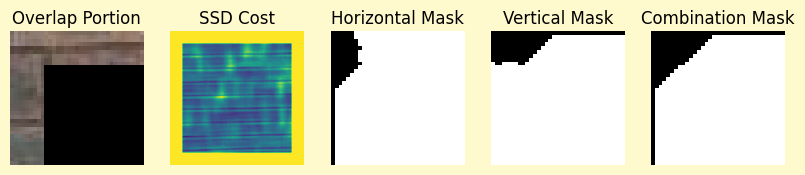

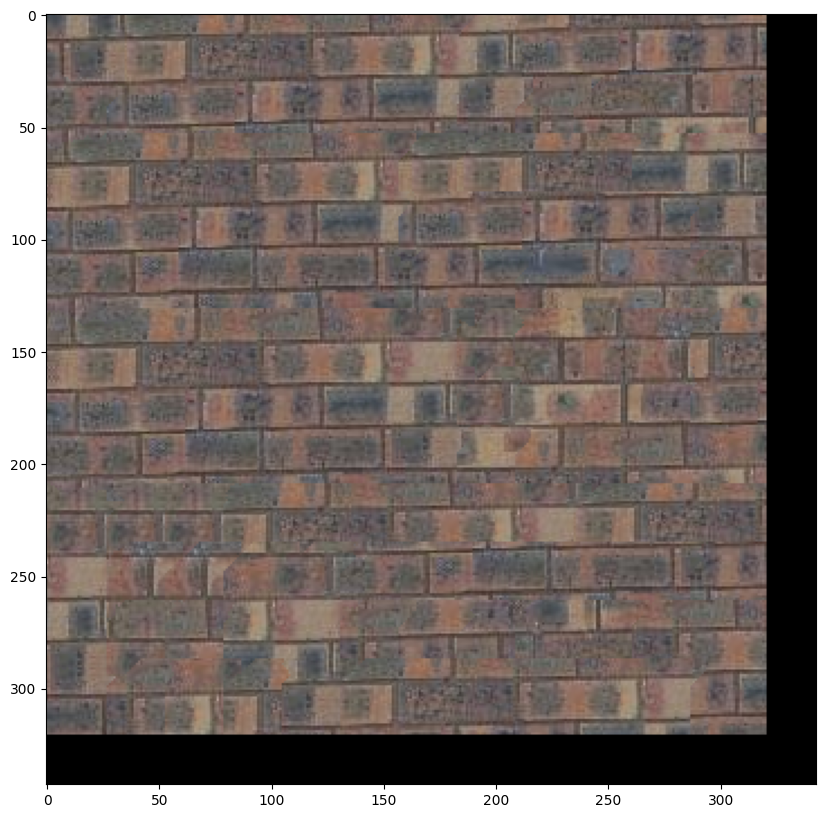

In [33]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 343  # change these parameters as needed
patch_size = 35
overlap = 9
tol = 1
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol, True)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)
    plt.imsave(os.path.join(output_dir, "seam1.png"), res)

#### Additional Quilting Results

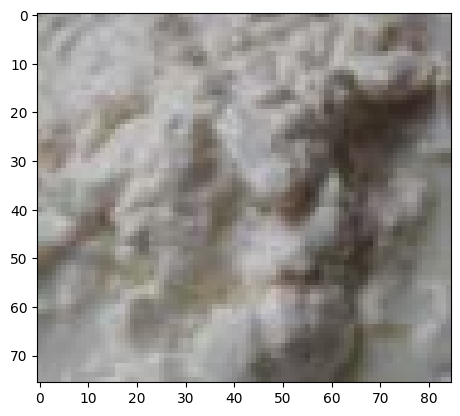

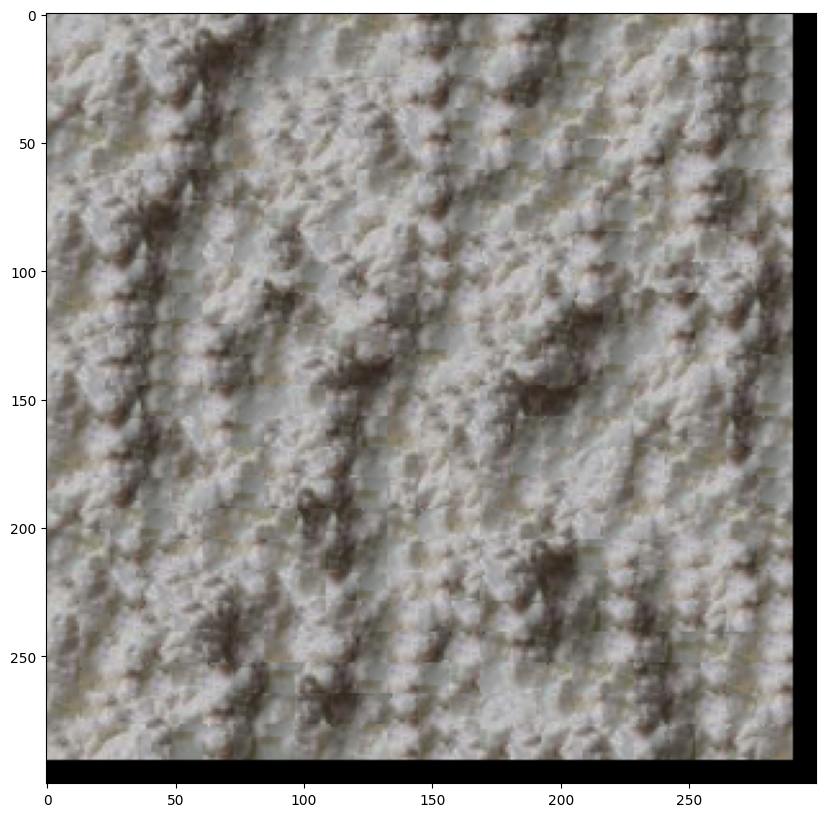

In [11]:
sample_img_fn = 'samples/white_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 15
overlap = 3
tol = 1
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)
    plt.imsave(os.path.join(output_dir, "seam2.png"), res)

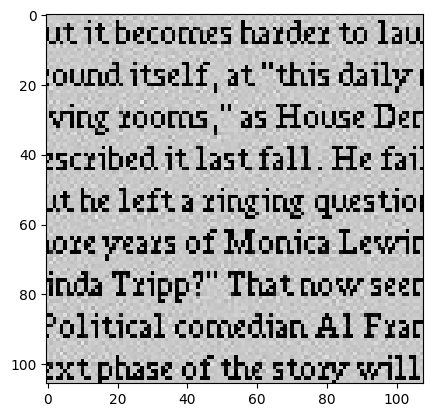

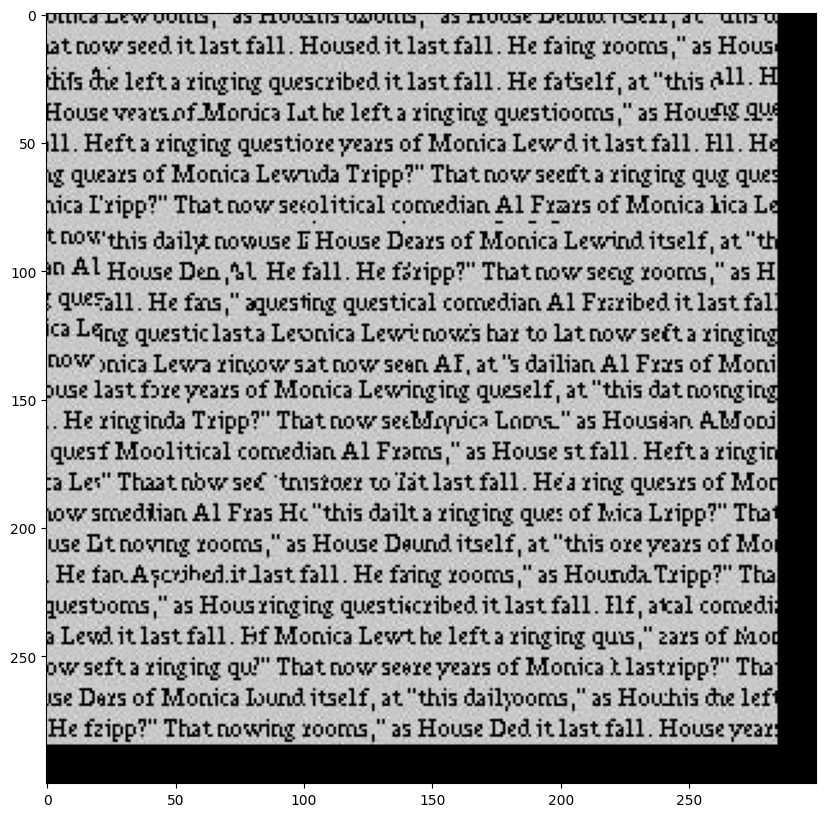

In [12]:
sample_img_fn = 'samples/text_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 5
tol = 1
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)
    plt.imsave(os.path.join(output_dir, "seam3.png"), res)

### part IV: Texture Transfer (30 pts)

In [13]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    def ssd_patch(template, mask):
      I = np.float32(sample / 255)
      T = np.float32(template / 255)
      M = np.float32(mask)
      template_masked = M * T
      ssd_cost = (template_masked ** 2).sum() -\
            2 * cv2.filter2D(I, ddepth=-1, kernel=template_masked) +\
            cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
      ssd_cost = np.sum(ssd_cost, axis=2)

      # Process the border to ensure not sampling them.
      half = patch_size // 2
      max_cost = ssd_cost.max()
      ssd_cost[:half+1, :] = max_cost
      ssd_cost[:, :half+1] = max_cost
      ssd_cost[-half-1:, :] = max_cost
      ssd_cost[:, -half-1:] = max_cost
      return ssd_cost


    def choose_sample(cost):
      idx = np.unravel_index(np.argsort(cost, axis=None), cost.shape)
      t = np.random.randint(0, tol)
      return idx[0][t], idx[1][t]

    height, width, channel = guidance_im.shape
    output = np.zeros((height, width, channel), guidance_im.dtype)
    mask_g = np.ones((patch_size, patch_size, sample.shape[2]), dtype=sample.dtype)

    half = patch_size // 2
    step = patch_size - overlap
    num_patches_c = (width - patch_size) // step + 1
    num_patches_r = (height - patch_size) // step + 1

    # Sample a random patch for the upper-left corner.
    x = np.random.randint(0, sample.shape[1] - patch_size + 1)
    y = np.random.randint(0, sample.shape[0] - patch_size + 1)
    patch = sample[y : y+patch_size, x : x+patch_size]
    output[0 : patch_size, 0 : patch_size] = patch

    # Process the first row.
    mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=sample.dtype)
    mask[:, 0:overlap, :] = 1
    for col in range(num_patches_c):
      template = output[0:patch_size, col*step : col*step+patch_size]
      template_g = guidance_im[0:patch_size, col*step : col*step+patch_size]
      cost_s = ssd_patch(template, mask)
      cost_g = ssd_patch(template_g, mask_g)
      cost = alpha * cost_s + (1 - alpha) * cost_g
      r, c = choose_sample(cost)
      patch = sample[r-half : r+half+1, c-half : c+half+1]

      err_patch = np.sum((template - patch)**2, axis=2)
      max_err = err_patch.max()
      err_patch[:, overlap:patch_size] = max_err
      cut_mask = cut(err_patch.T).T.astype(sample.dtype)
      cut_mask = np.repeat(cut_mask[:,:,np.newaxis], 3, axis=2)
      seam = cut_mask * patch + np.logical_not(cut_mask) * template
      output[0:patch_size, col*step : col*step+patch_size] = seam

    # Process the first column.
    mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=sample.dtype)
    mask[0:overlap, :, :] = 1
    for row in range(num_patches_r):
      template = output[row*step : row*step+patch_size, 0:patch_size]
      template_g = guidance_im[row*step : row*step+patch_size, 0:patch_size]
      cost_s = ssd_patch(template, mask)
      cost_g = ssd_patch(template_g, mask_g)
      cost = alpha * cost_s + (1 - alpha) * cost_g
      r, c = choose_sample(cost)
      patch = sample[r-half : r+half+1, c-half : c+half+1]

      err_patch = np.sum((template - patch)**2, axis=2)
      max_err = err_patch.max()
      err_patch[overlap:patch_size, :] = max_err
      cut_mask = cut(err_patch).astype(sample.dtype)
      cut_mask = np.repeat(cut_mask[:,:,np.newaxis], 3, axis=2)
      seam = cut_mask * patch + np.logical_not(cut_mask) * template
      output[row*step : row*step+patch_size, 0:patch_size] = seam

    # Process the remaining patches.
    mask = np.zeros((patch_size, patch_size, sample.shape[2]), dtype=sample.dtype)
    mask[0:overlap, :, :] = 1
    mask[:, 0:overlap, :] = 1
    for row in range(1, num_patches_r):
      for col in range(1, num_patches_c):
        template = output[row*step : row*step+patch_size, col*step : col*step+patch_size]
        template_g = guidance_im[row*step : row*step+patch_size, col*step : col*step+patch_size]
        cost_s = ssd_patch(template, mask)
        cost_g = ssd_patch(template_g, mask_g)
        cost = alpha * cost_s + (1 - alpha) * cost_g
        r, c = choose_sample(cost)
        patch = sample[r-half : r+half+1, c-half : c+half+1]

        err_patch = np.sum((template - patch)**2, axis=2)
        max_err = err_patch.max()
        err_patch[overlap:patch_size, :] = max_err
        err_patch[:, overlap:patch_size] = max_err
        cut_mask1 = cut(err_patch.T).T.astype(sample.dtype)
        cut_mask2 = cut(err_patch).astype(sample.dtype)
        cut_mask = np.logical_and(cut_mask1, cut_mask2).astype(sample.dtype)
        cut_mask = np.repeat(cut_mask[:,:,np.newaxis], 3, axis=2)
        seam = cut_mask * patch + np.logical_not(cut_mask) * template.copy()
        output[row*step : row*step+patch_size, col*step : col*step+patch_size] = seam

    return output

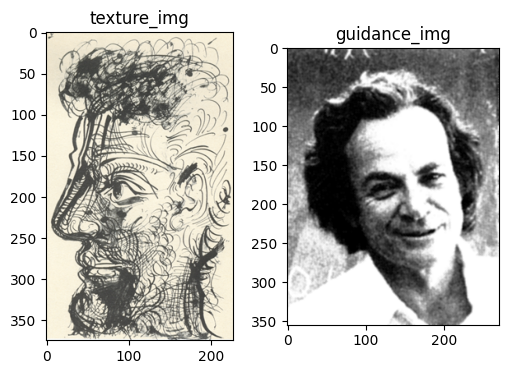

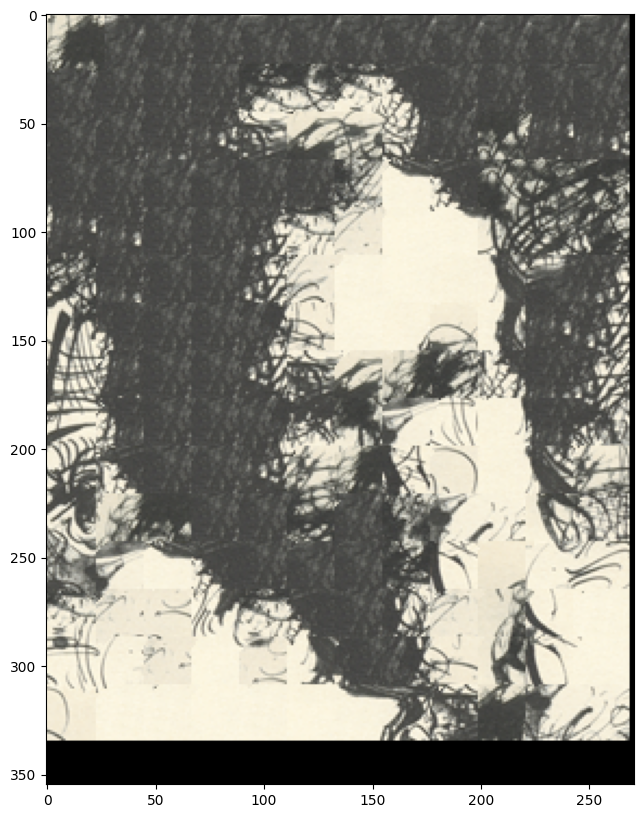

In [14]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/sketch.tiff'
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)

guidance_img_fn = 'samples/feynman.tiff'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
axes[0].imshow(texture_img)
axes[0].set_title('texture_img')
axes[1].imshow(guidance_img)
axes[1].set_title('guidance_img')
plt.show()

patch_size = 27
overlap = 5
tol = 1
alpha = 0.9
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)
plt.imsave(os.path.join(output_dir, "transfer1.png"), res)

plt.figure(figsize=(10,10))
plt.imshow(res)
plt.show()

--2024-11-24 22:43:42--  http://raw.githubusercontent.com/luojt2022/luojt2022.github.io/refs/heads/main/CS180-Projects/image_quilting/media/orange_texture.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/luojt2022/luojt2022.github.io/refs/heads/main/CS180-Projects/image_quilting/media/orange_texture.jpg [following]
--2024-11-24 22:43:42--  https://raw.githubusercontent.com/luojt2022/luojt2022.github.io/refs/heads/main/CS180-Projects/image_quilting/media/orange_texture.jpg
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28420 (28K) [image/jpeg]
Saving to: ‘orange_texture.jpg’

orange_texture.jpg  10

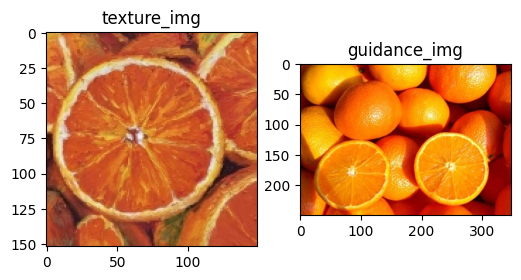

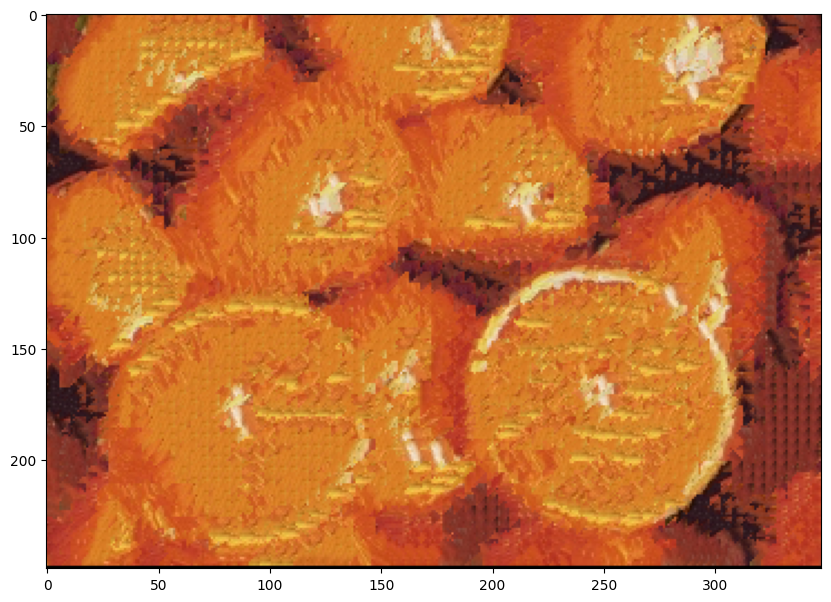

In [15]:
!wget raw.githubusercontent.com/luojt2022/luojt2022.github.io/refs/heads/main/CS180-Projects/image_quilting/media/orange_texture.jpg -O orange_texture.jpg
!wget raw.githubusercontent.com/luojt2022/luojt2022.github.io/refs/heads/main/CS180-Projects/image_quilting/media/orange.jpg -O orange.jpg

texture_img_fn = 'orange_texture.jpg'
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)

guidance_img_fn = 'orange.jpg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
axes[0].imshow(texture_img)
axes[0].set_title('texture_img')
axes[1].imshow(guidance_img)
axes[1].set_title('guidance_img')
plt.show()

patch_size = 13
overlap = 8
tol = 1
alpha = 0.3
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)
plt.imsave(os.path.join(output_dir, "transfer2.png"), res)

plt.figure(figsize=(10,10))
plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [16]:
# Generate a Gaussian stack.
def build_gaussian_stack(image, kernel_size, sigma, level):
    stack = []
    stack.append(image)
    for _ in range(level):
        stack.append(cv2.GaussianBlur(stack[-1], kernel_size, sigma))
    return stack

# Generate a Laplacian stack from the given Gaussian stack.
def build_laplacian_stack(gaussian_stack):
    laplacian_stack = []
    N = len(gaussian_stack) - 1
    for i in range(N):
        laplacian_stack.append(gaussian_stack[i] - gaussian_stack[i + 1])
    laplacian_stack.append(gaussian_stack[N])
    return laplacian_stack

# Normalize the image.
def normalize(stack):
    for i in range(len(stack)):
        stack[i] = (stack[i] - stack[i].min()) / (stack[i].max() - stack[i].min())

# Set up some parameters in this part.
level = 4
kernel_size = (25, 25)
sigma = 5

--2024-11-24 22:44:32--  https://raw.githubusercontent.com/luojt2022/luojt2022.github.io/refs/heads/main/CS180-Projects/image_quilting/media/hepburn.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51102 (50K) [image/jpeg]
Saving to: ‘hepburn.jpg’

hepburn.jpg         100%[===================>]  49.90K  --.-KB/s    in 0.01s   

2024-11-24 22:44:32 (3.62 MB/s) - ‘hepburn.jpg’ saved [51102/51102]



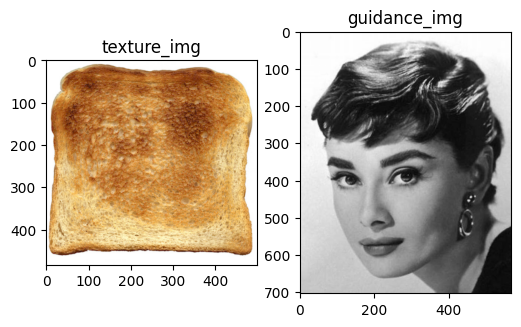

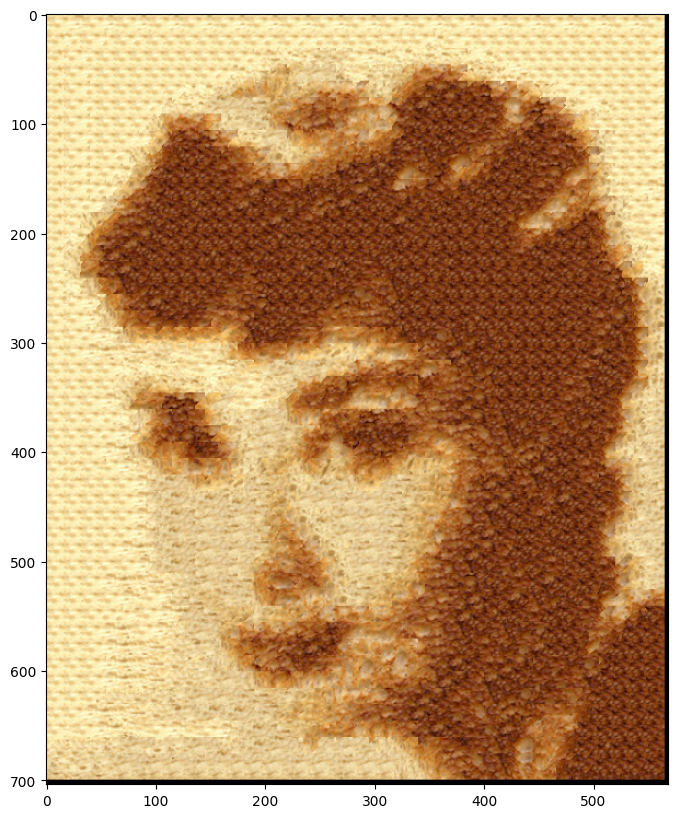

In [17]:
!wget https://raw.githubusercontent.com/luojt2022/luojt2022.github.io/refs/heads/main/CS180-Projects/image_quilting/media/hepburn.jpg -O hepburn.jpg

texture_img_fn = 'samples/toast.jpg'
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
texture_img_cut = texture_img[55:445, 35:460]

guidance_img_fn = 'hepburn.jpg'
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_cut = cv2.resize(guidance_img, (150, 225))

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
axes[0].imshow(texture_img)
axes[0].set_title('texture_img')
axes[1].imshow(guidance_img)
axes[1].set_title('guidance_img')
plt.show()

patch_size = 25
overlap = 10
tol = 1
alpha = 0.7
res = texture_transfer(texture_img_cut, patch_size, overlap, tol, guidance_img, alpha)
plt.imsave(os.path.join(output_dir, "transfer_blend.png"), res)

plt.figure(figsize=(10,10))
plt.imshow(res)
plt.show()

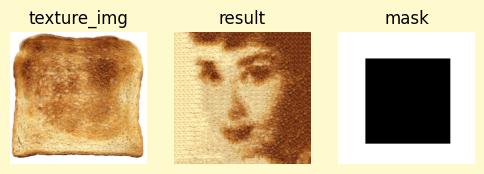

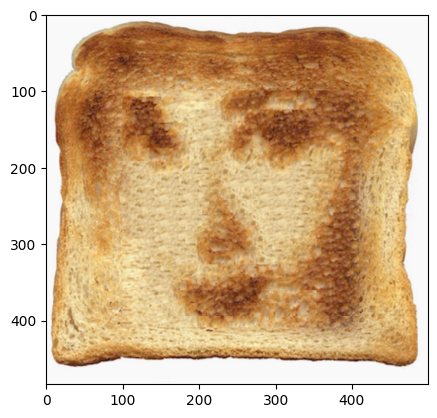

In [19]:
level = 2

texture_img_float = np.float32(texture_img) / 255.0
gaussian_stack1 = build_gaussian_stack(texture_img_float, (15, 15), 3, level)
laplacian_stack1 = build_laplacian_stack(gaussian_stack1)

h, w, _ = texture_img.shape
res_cut = res[250:680, 0:480]
res_cut = cv2.resize(res_cut, (w, h))
res_cut_float = np.float32(res_cut) / 255.0
gaussian_stack2 = build_gaussian_stack(res_cut_float, (49, 49), 21, level)
laplacian_stack2 = build_laplacian_stack(gaussian_stack2)

mask = np.ones(texture_img.shape)
mask[100:410, 100:410, :] = 0
mask_gaussian_stack = build_gaussian_stack(mask, (35, 35), 15, level)

fig, axes = plt.subplots(1, 3, figsize=(6, 4))
fig.patch.set_facecolor('#fffacd')
axes[0].imshow(texture_img)
axes[0].set_title('texture_img')
axes[0].axis('off')
axes[1].imshow(res_cut)
axes[1].set_title('result')
axes[1].axis('off')
axes[2].imshow(mask)
axes[2].set_title('mask')
axes[2].axis('off')
plt.savefig(os.path.join(output_dir, "blend_mask.png"), dpi=300, bbox_inches='tight')
plt.show()

blend_stack = []
for l1, l2, m in zip(laplacian_stack1, laplacian_stack2, mask_gaussian_stack):
  blend_stack.append(l1 * m + l2 * (1 - m))
blend_img = np.zeros(texture_img.shape)
reverse_stack = reversed(blend_stack)
for laplacian in reverse_stack:
  blend_img = laplacian + blend_img
blend_img = (blend_img - blend_img.min()) / (blend_img.max() - blend_img.min())
plt.imsave(os.path.join(output_dir, "blend.png"), blend_img)
plt.imshow(blend_img)
plt.show()

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).